In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
class Network(object):
    def __init__(self):
        self.layers = None
        self.createLayers()

    # See what data_format='channels_last' mean in MaxPooling2D ?
    def createLayers(self):
        self.layers = []
        self.layers.append(tf.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu))
        self.layers.append(tf.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu))
        self.layers.append(tf.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
        
        self.layers.append(tf.layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu))
        self.layers.append(tf.layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu))
        self.layers.append(tf.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
        
        self.layers.append(tf.layers.Dense(units=512, activation=tf.nn.relu))
        self.layers.append(tf.layers.Dense(units=100))

    def forward(self, x, apply_dropout, keep_prob_input=1.0, keep_prob_hidden=1.0):
        layer_output = []
        
        y = x
        
        if (apply_dropout):
            y = tf.nn.dropout(y, keep_prob_input)
            
        y = self.layers[0](y)
        layer_output.append(y)
        y = self.layers[1](y)
        layer_output.append(y)
        y = self.layers[2](y)
        if (apply_dropout):
            y = tf.nn.dropout(y, keep_prob_hidden)
        layer_output.append(y)
        
        y = self.layers[3](y)
        layer_output.append(y)
        y = self.layers[4](y)
        layer_output.append(y)
        y = self.layers[5](y)
        if (apply_dropout):
            y = tf.nn.dropout(y, keep_prob_hidden)
        layer_output.append(y)
        
        y = tf.layers.flatten(y)
        y = self.layers[6](y)
        if (apply_dropout):
            y = tf.nn.dropout(y, keep_prob_hidden)
        layer_output.append(y)
        y = self.layers[7](y)
        layer_output.append(y)
        
        return y, layer_output

    def getLayerVariables(self):
        l = []
        for i in range(len(self.layers)):
            l.extend(self.layers[i].variables)
        return l
    def name(self):
        return 'n1'

In [7]:
network = Network()

In [11]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints0/'
summaries_path = cur_dir + 'summaries0/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    split = [list(np.arange(80))]
    task_weights = [0.8]
    for i in range(80, 100):
        split.append([i])
        task_weights.append(0.2/20)
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
    
    num_class = 100
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    max_intensity = np.max(f_train_data[b'data'])
    f_train_data[b'data'] = f_train_data[b'data'].astype(np.float32) / max_intensity
    f_test_data[b'data'] = f_test_data[b'data'].astype(np.float32) / max_intensity
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [12]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [14]:
tuner.setPerExampleAppend(1.0)

In [15]:
t = 20
learning_rates = [1e-3]
fisher_multipliers = [0.0]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(fisher_multipliers, dropout_input_probs, dropout_hidden_probs, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['fisher_multiplier'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['learning_rate'] = hparams_tuple[3]
    hparams.append(cur_dict)
    
for i in range(t + 1):
    tuner.hparams_list[i] = hparams
    
num_hparams = len(hparams)
TEST_BATCH_SIZE = 128

In [18]:
checkpoint_paths = []
summaries_paths = []
num_trials = 5
for i in range(num_trials):
    checkpoint_paths.append(cur_dir + 'checkpoints' + str(i) + '/')
    summaries_paths.append(cur_dir + 'summaries' + str(i) + '/')
    if not os.path.exists(checkpoint_paths[i]):
        os.makedirs(checkpoint_paths[i])
    if not os.path.exists(summaries_paths[i]):
        os.makedirs(summaries_paths[i])

In [20]:
test_accuracies = [[] for _ in range(num_trials)]
for i in range(num_trials):
    tuner.checkpoint_path = checkpoint_paths[i]
    tuner.summaries_path = summaries_paths[i]
    tuner.classifier.checkpoint_path = checkpoint_paths[i]
    for task_no in range(tuner.num_tasks):
        num_epochs = 60
        num_updates = math.ceil(tuner.task_list[task_no].train.images.shape[0] / BATCH_SIZE) * num_epochs
        tuner.tuneOnTask(task_no, BATCH_SIZE, num_updates=num_updates, save_weights=False)
        test_accuracy = tuner.test(task_no, TEST_BATCH_SIZE, restore_model=False)
        test_accuracies[i].append(test_accuracy)

INFO:tensorflow:Restoring parameters from ./checkpoints2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=0.ckpt-4800
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=1
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=0
INFO:tensorflow:Restoring parameters from ./checkpoints2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=0.ckpt-4800
epochs: 60.000000, final train loss: 0.433323, validation accuracies: [0.368125 0.      ]
best epochs: 50.000000, best_avg: 0.363580, validation accuracies: [0.368125 0.      ]
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=1
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,le

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=5 at time step 200
calculating penultimate output...
time taken: %f 3.4702048301696777
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=5.ckpt-200
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=6
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=5
INFO:tensorflow:Restoring parameters from ./checkpoints2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=5.ckpt-200
epochs: 60.000000, final train loss: 0.460851, validation accuracies: [0.33625    0.         0.25       0.64999998 0.30000001 0.30000001
 0.34999999]
best epochs:

epochs: 51.000000, final train loss: 0.756011, validation accuracies: [0.34875    0.05       0.30000001 0.64999998 0.15000001 0.15000001
 0.60000002 0.15000001 0.25       0.1        0.2       ]
best epochs: 50.000000, best_avg: 0.338889, validation accuracies: [0.34875    0.05       0.30000001 0.64999998 0.15000001 0.15000001
 0.60000002 0.15000001 0.25       0.1        0.2       ]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=10 at time step 200
calculating penultimate output...
time taken: %f 2.9287607669830322
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=10.ckpt-200
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=11
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_mu

epochs: 51.000000, final train loss: 0.593831, validation accuracies: [0.33625    0.1        0.25       0.34999999 0.1        0.30000001
 0.40000001 0.44999999 0.40000001 0.2        0.34999999 0.25
 0.64999998 0.         0.15000001]
best epochs: 50.000000, best_avg: 0.328191, validation accuracies: [0.33625    0.1        0.25       0.34999999 0.1        0.30000001
 0.40000001 0.44999999 0.40000001 0.2        0.34999999 0.25
 0.64999998 0.         0.15000001]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=14 at time step 200
calculating penultimate output...
time taken: %f 2.8870279788970947
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=14.ckpt-200
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=15
Res

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=17
INFO:tensorflow:Restoring parameters from ./checkpoints2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=17.ckpt-0
epochs: 1.000000, final train loss: 1.455313, validation accuracies: [0.324375   0.1        0.2        0.5        0.15000001 0.30000001
 0.60000002 0.34999999 0.40000001 0.2        0.25       0.55000001
 0.55000001 0.1        0.1        0.60000002 0.1        0.
 0.        ]
best epochs: 0.000000, best_avg: 0.316327, validation accuracies: [0.324375   0.1        0.2        0.5        0.15000001 0.30000001
 0.60000002 0.34999999 0.40000001 0.2        0.25       0.55000001
 0.55000001 0.1        0.1        0.60000002 0.1        0.
 0.        ]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.001,old:new=1.0,task=18 at time step 0
calculati

AttributeError: 'NoneType' object has no attribute 'model_checkpoint_path'

In [28]:
print(test_accuracies[1])

[]


cur_best_avg: 3.000000e-01, num_updates: 100
best val_acc: [0.31       0.1        0.15000001 0.5        0.1        0.1
 0.60000002 0.2        0.40000001 0.1        0.40000001 0.30000001
 0.55000001 0.2        0.25       0.69999999 0.25       0.25
 0.         0.05       0.        ]


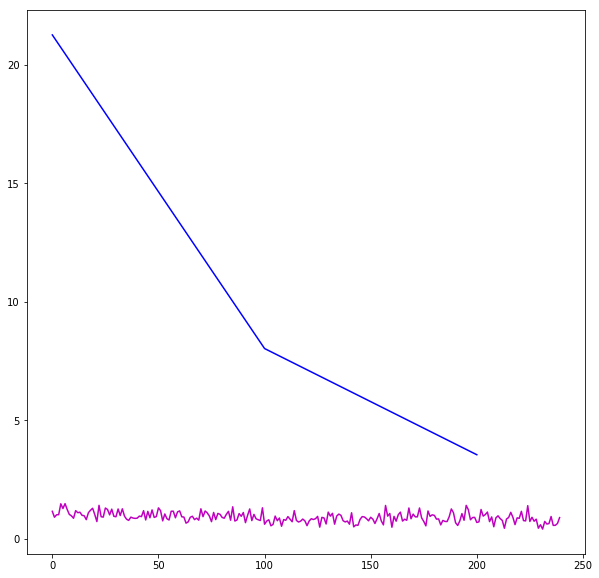

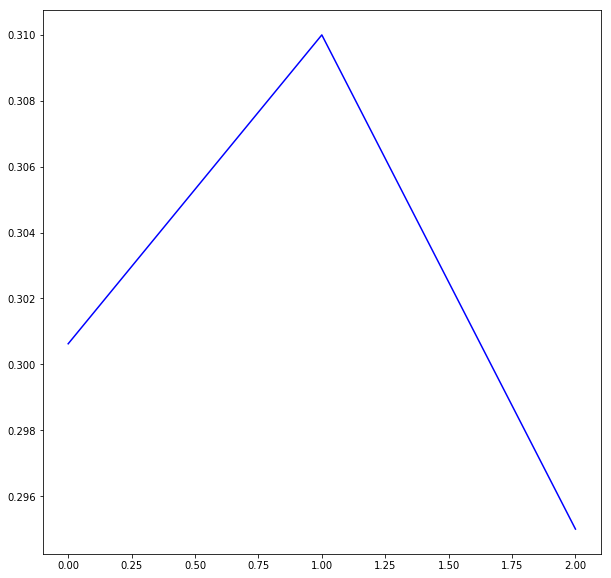

In [33]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(best_hparams, tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, len(cur_res['loss']), tuner.eval_frequency)
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, cur_best_avg_updates // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [38]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [47]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: argparse


PicklingError: Can't pickle <built-in function input>: it's not the same object as builtins.input